# Load the datasets and imports

<font color ='red'>Note:</font> We are loading a big dataset with 2985217 rows and 58 columns. It requires at least 2GB of free RAM to load.

In [1]:
# imports here:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load datasets here:
train_data = pd.read_csv('../input/train_2016_v2.csv')
data = pd.read_csv('../input/properties_2016.csv', low_memory=False)
data = pd.merge(data, train_data, how='left', on='parcelid')
data['transactiondate'] = pd.to_datetime(data['transactiondate'])

'The dataset has %d rows and %d columns' % data.shape

'The dataset has 2985342 rows and 60 columns'

# Business Understanding
<b>10 points</b>

<i>
<b>Description:</b><br/>
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.
</i>

<b>Answer:</b><br/>
This is a dataset from a Kaggle competion: "Zillow Prize: Zillow’s Home Value Prediction (Zestimate)". It has a submittion deadline in about 3 months and $1,200,000 Prize Money.

Zillow is one of the leading real estate and rental marketplace platforms. They have a model which estimates a property price based on the property description and this call this estimation Zestimate. As with every real world model, Zestimate has some error in the prediction. In this competition, Zillow is asking us to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as:

$logerror=log(Zestimate)−log(SalePrice)$

where logerror < 0 will represent Zestimate been lower than the actual sell price and logerror > 0 represent Zestimate has estimated the property to cost more than the price it got sold.

We are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016. The dataset contains:
- ID for the listing 
- 57 variables describing the property as square foots
number of bedrooms
- two result variables: logerror and transaction date

Train and test datasets:
- train data with <b>90275 rows</b> (containing logerror and transaction date) has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.
- test data with <b>2895067 rows</b> in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

The competition comes down to: <b>can we build a model that estimates better than Zillow's?</b>

To measure the effectiveness of a good prediction algorithm we will first use cross valiadated splitting of the train dataset to train/valid/test and estimate our test prediction error. A final prediction error will be estimated by kaggle when we submit our predictions.

This notebook will be used by us as documentation for the dataset. Here is what we do:
- Clean the dataset. We are are looking at every variable individually in order to remove high outliers and deal with missing values
- Create a table with all variable names, attribute types, range and description. We will use this table as a refference
- Get some statistical summary of the dataset
- Visualize Attributes in order to get familiar with ranges, distibutions
- Visualize relationships between attributes
- Identify and explain interesting relationships between features and the class you are trying to predict
- Add New Features
- And more..

In [2]:
# code here

# Data Meaning Type
<b>10 points</b>

<i>
<b>Description:</b><br/>
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.
</i>

<b>Answer:</b><br/>
...
![data_types](../img/data_types.png)

In [3]:
from IPython.display import display, HTML

# data type should be one of:
# 

variables_description = [
['airconditioningtypeid', 'nominal', 'TBD', 'Type of cooling system present in the home (if any)']
,['architecturalstyletypeid', 'nominal', 'TBD', 'Architectural style of the home (i.e. ranch, colonial, split-level, etc…)']
,['basementsqft', 'ratio', 'TBD', 'Finished living area below or partially below ground level']
,['bathroomcnt', 'ordinal', 'TBD', 'Number of bathrooms in home including fractional bathrooms']
,['bedroomcnt', 'ordinal', 'TBD', 'Number of bedrooms in home']
,['buildingqualitytypeid', 'ordinal', 'TBD', 'Overall assessment of condition of the building from best (lowest) to worst (highest)']
,['buildingclasstypeid', 'nominal', 'TBD', 'The building framing type (steel frame, wood frame, concrete/brick)']
,['calculatedbathnbr', 'ordinal', 'TBD', 'Number of bathrooms in home including fractional bathroom']
,['decktypeid', 'nominal', 'TBD', 'Type of deck (if any) present on parcel']
,['threequarterbathnbr', 'ordinal', 'TBD', 'Number of 3/4 bathrooms in house (shower + sink + toilet)']
,['finishedfloor1squarefeet', 'ratio', 'TBD', 'Size of the finished living area on the first (entry) floor of the home']
,['calculatedfinishedsquarefeet', 'ratio', 'TBD', 'Calculated total finished living area of the home']
,['finishedsquarefeet6', 'ratio', 'TBD', 'Base unfinished and finished area']
,['finishedsquarefeet12', 'ratio', 'TBD', 'Finished living area']
,['finishedsquarefeet13', 'ratio', 'TBD', 'Perimeter living area']
,['finishedsquarefeet15', 'ratio', 'TBD', 'Total area']
,['finishedsquarefeet50', 'ratio', 'TBD', 'Size of the finished living area on the first (entry) floor of the home']
,['fips', 'nominal', 'TBD', 'Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details']
,['fireplacecnt', 'ordinal', 'TBD', 'Number of fireplaces in a home (if any)']
,['fireplaceflag', 'ordinal', 'TBD', 'Is a fireplace present in this home']
,['fullbathcnt', 'ordinal', 'TBD', 'Number of full bathrooms (sink, shower + bathtub, and toilet) present in home']
,['garagecarcnt', 'ordinal', 'TBD', 'Total number of garages on the lot including an attached garage']
,['garagetotalsqft', 'ratio', 'TBD', 'Total number of square feet of all garages on lot including an attached garage']
,['hashottuborspa', 'ordinal', 'TBD', 'Does the home have a hot tub or spa']
,['heatingorsystemtypeid', 'nominal', 'TBD', 'Type of home heating system']
,['latitude', 'interval', 'TBD', 'Latitude of the middle of the parcel multiplied by 10e6']
,['longitude', 'interval', 'TBD', 'Longitude of the middle of the parcel multiplied by 10e6']
,['lotsizesquarefeet', 'ratio', 'TBD', 'Area of the lot in square feet']
,['numberofstories', 'ordinal', 'TBD', 'Number of stories or levels the home has']
,['parcelid', 'nominal', 'TBD', 'Unique identifier for parcels (lots)']
,['poolcnt', 'ordinal', 'TBD', 'Number of pools on the lot (if any)']
,['poolsizesum', 'ratio', 'TBD', 'Total square footage of all pools on property']
,['pooltypeid10', 'nominal', 'TBD', 'Spa or Hot Tub']
,['pooltypeid2', 'nominal', 'TBD', 'Pool with Spa/Hot Tub']
,['pooltypeid7', 'nominal', 'TBD', 'Pool without hot tub']
,['propertycountylandusecode', 'nominal', 'TBD', 'County land use code i.e. it\'s zoning at the county level']
,['propertylandusetypeid', 'nominal', 'TBD', 'Type of land use the property is zoned for']
,['propertyzoningdesc', 'nominal', 'TBD', 'Description of the allowed land uses (zoning) for that property']
,['rawcensustractandblock', 'nominal', 'TBD', 'Census tract and block ID combined - also contains blockgroup assignment by extension']
,['censustractandblock', 'nominal', 'TBD', 'Census tract and block ID combined - also contains blockgroup assignment by extension']
,['regionidcounty', 'nominal', 'TBD', 'County in which the property is located']
,['regionidcity', 'nominal', 'TBD', 'City in which the property is located (if any)']
,['regionidzip', 'nominal', 'TBD', 'Zip code in which the property is located']
,['regionidneighborhood', 'nominal', 'TBD', 'Neighborhood in which the property is located']
,['roomcnt', 'ordinal', 'TBD', 'Total number of rooms in the principal residence']
,['storytypeid', 'nominal', 'TBD', 'Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.']
,['typeconstructiontypeid', 'nominal', 'TBD', 'What type of construction material was used to construct the home']
,['unitcnt', 'ordinal', 'TBD', 'Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)']
,['yardbuildingsqft17', 'interval', 'TBD', 'Patio in yard']
,['yardbuildingsqft26', 'interval', 'TBD', 'Storage shed/building in yard']
,['yearbuilt', 'interval', 'TBD', 'The Year the principal residence was built']
,['taxvaluedollarcnt', 'ratio', 'TBD', 'The total tax assessed value of the parcel']
,['structuretaxvaluedollarcnt', 'ratio', 'TBD', 'The assessed value of the built structure on the parcel']
,['landtaxvaluedollarcnt', 'ratio', 'TBD', 'The assessed value of the land area of the parcel']
,['taxamount', 'ratio', 'TBD', 'The total property tax assessed for that assessment year']
,['assessmentyear', 'ordinal', 'TBD', 'The year of the property tax assessment']
,['taxdelinquencyflag', 'nominal', 'TBD', 'Property taxes for this parcel are past due as of 2015']
,['taxdelinquencyyear', 'interval', 'TBD', 'Year']
]
variables = pd.DataFrame(variables_description, columns=['name', 'type', 'scale','description'])
variables = variables.set_index('name')
rows = ['<tr><th>Variable</th><th>Type</th><th>Scale</th><th>Description</th></tr>']
for row in variables_description:
    # add scale if TBD
    if row[2] == 'TBD':
        vname, vtype = row[:2]
        if vtype in ['nominal', 'ordinal']:

            uniques = data[vname].unique()
            uniques = list(uniques.astype(str))
            if len(uniques) < 10:
                
                row[2] = '[%s]' % ', '.join(uniques)
            else:
                row[2] = '[%s]' % (', '.join(uniques[:5]) + ', ... (%d More)' % len(uniques))

        if vtype in ['ratio', 'interval']:
            row[2] = '(%d, %d)' % (data[vname].min(), data[vname].max())
        
    rows.append('<tr ><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>' % tuple(row))
HTML('<table>%s</table>' % ''.join(rows))

Variable,Type,Scale,Description
airconditioningtypeid,nominal,"[nan, 1.0, 13.0, 5.0, 11.0, 9.0, 12.0, 3.0]",Type of cooling system present in the home (if any)
architecturalstyletypeid,nominal,"[nan, 7.0, 21.0, 8.0, 2.0, 3.0, 5.0, 10.0, 27.0]","Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
basementsqft,ratio,"(20, 8516)",Finished living area below or partially below ground level
bathroomcnt,ordinal,"[0.0, 2.0, 4.0, 3.0, 1.0, ... (38 More)]",Number of bathrooms in home including fractional bathrooms
bedroomcnt,ordinal,"[0.0, 4.0, 5.0, 2.0, 3.0, ... (22 More)]",Number of bedrooms in home
buildingqualitytypeid,ordinal,"[nan, 7.0, 4.0, 10.0, 1.0, ... (13 More)]",Overall assessment of condition of the building from best (lowest) to worst (highest)
buildingclasstypeid,nominal,"[nan, 3.0, 4.0, 5.0, 2.0, 1.0]","The building framing type (steel frame, wood frame, concrete/brick)"
calculatedbathnbr,ordinal,"[nan, 2.0, 4.0, 3.0, 1.0, ... (35 More)]",Number of bathrooms in home including fractional bathroom
decktypeid,nominal,"[nan, 66.0]",Type of deck (if any) present on parcel
threequarterbathnbr,ordinal,"[nan, 1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 7.0]",Number of 3/4 bathrooms in house (shower + sink + toilet)


# Data Quality
<b>15 points</b>

<i>
<b>Description:</b><br/>
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.
</i>

<b>Answer:</b><br/>
...

## Examining Distribution of missing values
It looks like there are obsorvations with most of variables missing.

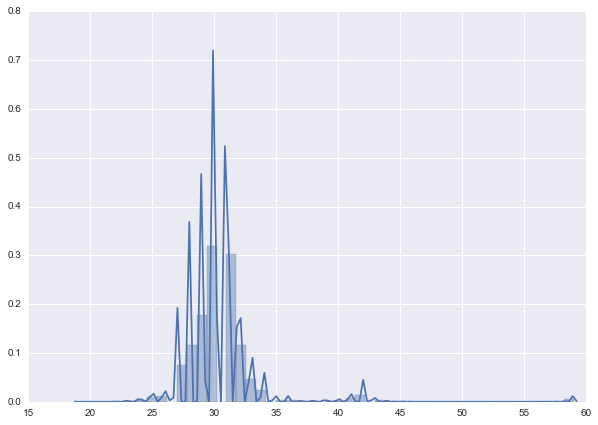

In [4]:
plt.rcParams['figure.figsize'] = [10, 7]

number_missing_per_row = data.isnull().sum(axis=1)
sns.distplot(number_missing_per_row);

### All obsorvations have a value for parcelid

In [5]:
data['parcelid'].isnull().sum()

0

### 0.38 percent of the data has only parcelid present and all other variables missing
We remove those obsorvations because they don't present any value

In [6]:
print(len(number_missing_per_row[number_missing_per_row >= 57]) / len(data) * 100)
data = data[number_missing_per_row < 57]

0.38310518526855547


### Missing values table:

In [7]:
missing_values = data.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values['Precent Missing'] = missing_values['Number Missing Values'] / len(data) * 100 
missing_values['Precent Missing'] = missing_values['Precent Missing'].replace(np.inf, 0)
missing_values

,Variable Name,Number Missing Values,Precent Missing
0,parcelid,0,0.000000
1,airconditioningtypeid,2162353,72.710897
2,architecturalstyletypeid,2967843,99.796160
3,basementsqft,2972277,99.945257
4,bathroomcnt,25,0.000841
5,bedroomcnt,13,0.000437
6,buildingclasstypeid,2961276,99.575339
7,buildingqualitytypeid,1035337,34.814058
8,calculatedbathnbr,117481,3.950395
9,decktypeid,2956809,99.425133


## Examining variables for missing values and outliers individually

In [8]:
def fix_outliers(data, column):
    mean = data[column].mean()
    std = data[column].std()
    max_value = mean + std * 5
    min_value = mean - std * 5
    
    if data[column].max() < max_value and data[column].min() > min_value:
        print('No outliers found')
        return
    
    print('Outliers found!')
    
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=[15, 7])
    
    sns.boxplot(data[column].dropna(), ax=ax0).set_title('Before');
    sns.distplot(data[column].dropna(), ax=ax2).set_title('Before');

    data.loc[data[column] > max_value, column] = max_value
    data.loc[data[column] < min_value, column] = min_value
    
    sns.boxplot(data[column].dropna(), ax=ax1).set_title('After');
    sns.distplot(data[column].dropna(), ax=ax3).set_title('After');

### Variable: finishedsquarefeet6 - Base unfinished and finished area
Has datatype: ratio and 99.260167 percent of values missing 

We will not use it in our analysis:

In [9]:
del data['finishedsquarefeet6']

### Variable: fips - Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details
Has datatype: nominal with values [6037.0, 6059.0, 6111.0] and no missing values

I fix the column datatype to integer.

In [10]:
data['fips'] = data['fips'].astype(np.int32)

### Variable: fireplacecnt - Number of fireplaces in a home (if any)
Has datatype: ordinal and 89.486882 percent of values missing 

In this dataset, missing value represents 0 fireplaces. We replace all missing values with zero and change the column datatype to integer.

In [11]:
print('Before', data['fireplacecnt'].unique())
data['fireplacecnt'] = data['fireplacecnt'].fillna(0).astype(np.int32)
print('After', data['fireplacecnt'].unique())

Before [ nan   3.   1.   2.   4.   9.   5.   7.   6.   8.]
After [0 3 1 2 4 9 5 7 6 8]


### Variable: fullbathcnt - Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
Has datatype: ordinal and 3.95 percent of values missing 

We first replace its missing values with the valeues of bathroomcnt which is a similare measure. After that we have 25 obsorvations missing and we replace them with 0.

In [12]:
print('Before', data['fullbathcnt'].unique())
missing_fullbathcnt = data['fullbathcnt'].isnull()
data.loc[missing_fullbathcnt, 'fullbathcnt'] = data['bathroomcnt'][missing_fullbathcnt].fillna(0)
print('After', data['fullbathcnt'].unique())

Before [ nan   2.   4.   3.   1.   5.   7.   6.  10.   8.   9.  12.  11.  13.  14.
  20.  19.  15.  18.  16.  17.]
After [  0.     2.     4.     3.     1.     5.     7.     6.    10.     8.     9.
  12.    11.     7.5    2.5    4.5    1.5   13.    14.    20.     3.5   19.
   5.5   15.    18.    16.     1.75   6.5   17.     0.5    8.5 ]


### Variable: garagecarcnt - Total number of garages on the lot including an attached garage

Has datatype: ordinal and 70.298173 percent of values missing 

We assume a missing value will represent no garages and replace all missing values with zero.

In [13]:
data['garagecarcnt'] = data['garagecarcnt'].fillna(0).astype(np.int32)
print(data['garagecarcnt'].unique())

[ 0  2  4  1  3  5  7  6  8  9 12 11 10 13 14 15 25 21 18 17 24 19 16 20]


### Variable: garagetotalsqft - Total number of garages on the lot including an attached garage

Has datatype: ratio and 70.298173 percent of values missing 

We will first replace missing values where garagecarcnt is 0 with 0. 
We replace all outliers with a maximum value of (mean + 6 * std)

Outliers found!


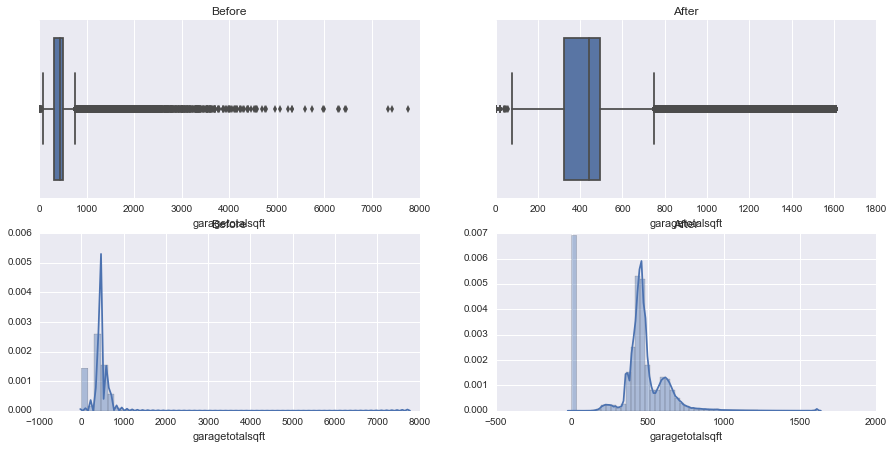

In [14]:
fix_outliers(data, 'garagetotalsqft')

data.loc[data['garagecarcnt'] == 0, 'garagetotalsqft'] = 0
assert data['garagetotalsqft'].isnull().sum() == 0

### Variable: hashottuborspa - Does the home have a hot tub or spa

Has datatype: ordinal and 97.679250 percent of values missing 

In this dataset missing values represent doesn't have a hot tub or spa. I will replace all missing values with 0 and all True values with 1.

In [15]:
print('Before', data['hashottuborspa'].unique())
data['hashottuborspa'] = data['hashottuborspa'].fillna(0).replace('True', 1).astype(np.int32)
print('After', data['hashottuborspa'].unique())

Before [nan True]
After [0 1]


### Variable: heatingorsystemtypeid - Type of home heating system

Has datatype: nominal and 39.255728 percent of values missing 

We replace all missing values with 0 which will represent a missing heating system type id.

In [16]:
print('Before', data['heatingorsystemtypeid'].unique())
data['heatingorsystemtypeid'] = data['heatingorsystemtypeid'].fillna(0).astype(np.int32)
print('After', data['heatingorsystemtypeid'].unique())

Before [ nan   2.   7.  20.   6.  13.  18.  24.  12.  10.   1.  14.  21.  11.  19.]
After [ 0  2  7 20  6 13 18 24 12 10  1 14 21 11 19]


### Variables: latitude and longitude

Has datatype: range and no missing values.

### Variable: lotsizesquarefeet - Area of the lot in square feet

Has datatype: ratio and 8.9 percent of values missing 

We replace all missing values with 0 which will represent no lot.
We replace all outliers with a maximum value of (mean + 6 * std)

Outliers found!


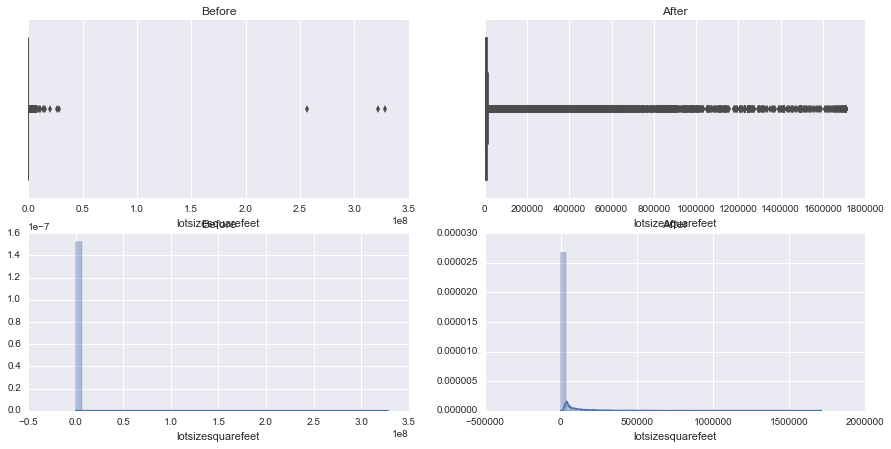

In [17]:
fix_outliers(data, 'lotsizesquarefeet')
data['lotsizesquarefeet'] = data['lotsizesquarefeet'].fillna(0)

### Variable: poolcnt - Number of pools on the lot (if any)

Has datatype: ordinal and 82.6 percent of values missing 

We replace all missing values with 0 which will represent no pools.

In [18]:
print('Before', data['poolcnt'].unique())
data['poolcnt'] = data['poolcnt'].fillna(0).astype(np.int32)
print('After', data['poolcnt'].unique())

Before [ nan   1.]
After [0 1]


### Variable: poolsizesum - Total square footage of all pools on property

Has datatype: ordinal and 99 percent of values missing 

We replace all missing values with 0 if number of pools is 0 or with the average poolsizesum otherwise.

Outliers found!


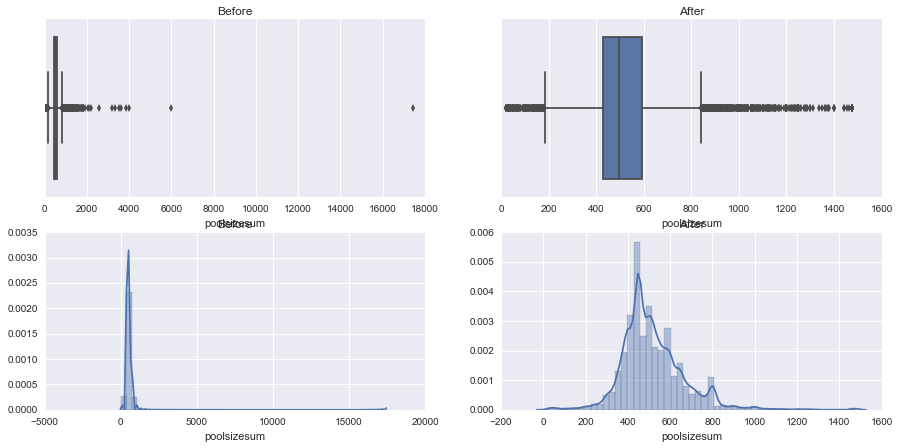

In [19]:
fix_outliers(data, 'poolsizesum')

data.loc[data['poolsizesum'].isnull(), 'poolsizesum'] = int(data['poolsizesum'].mean())
data.loc[data['poolcnt'] == 0, 'poolsizesum'] = 0

### Variable: pooltypeid10 - Spa or Hot Tub

Has datatype: ordinal and 98.8 percent of values missing 

We replace all missing values with 0 which will represent no Spa or Hot Tub.

In [20]:
print('Before', data['pooltypeid10'].unique())
data['pooltypeid10'] = data['pooltypeid10'].fillna(0).astype(np.int32)
print('After', data['pooltypeid10'].unique())

Before [ nan   1.]
After [0 1]


### Variable: yardbuildingsqft17 - sq feet of patio in yard

Has datatype: interval and 97.29 percent of values missing

We replace all missing values with 0 representing no patio

Outliers found!


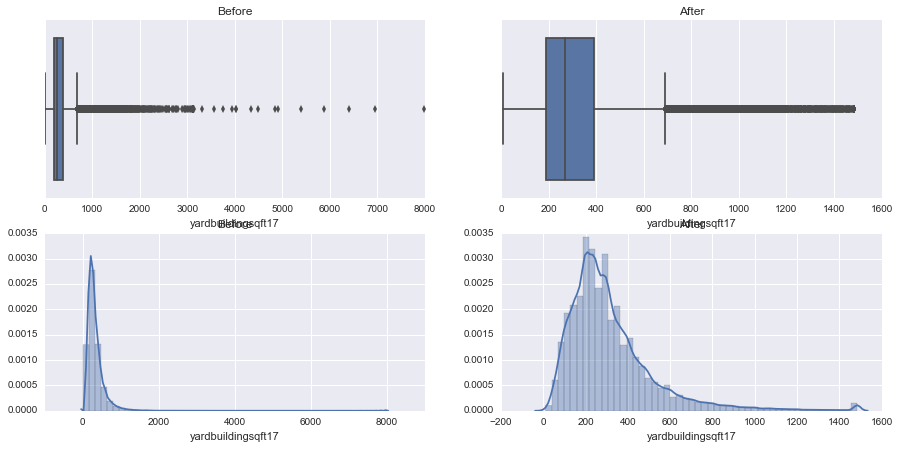

In [21]:
fix_outliers(data, 'yardbuildingsqft17')

data['yardbuildingsqft17'] = data['yardbuildingsqft17'].fillna(0).astype(np.int32)

### Variable: yardbuildingsqft26 - storage shed/building in yard

Has datatype: interval and 99.91 percent of values missing 

We replace all missing values with 0 which will represent no (square ft) storage shed or building in the yard.

Outliers found!


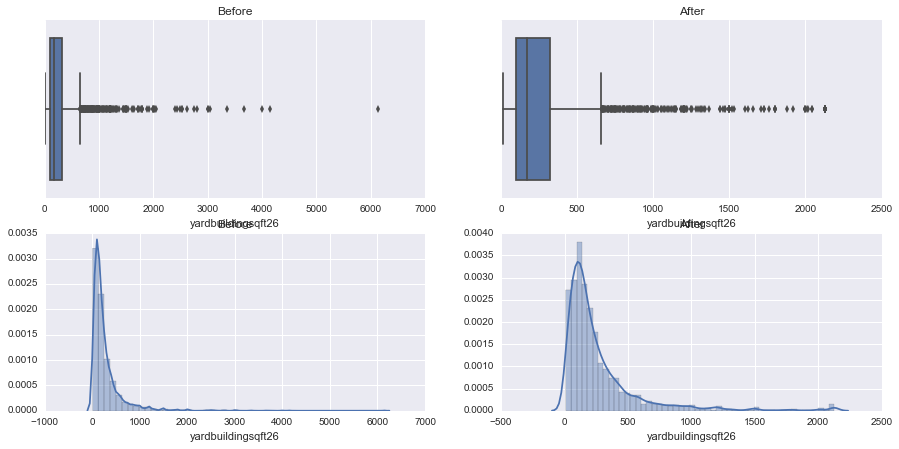

In [22]:
fix_outliers(data, 'yardbuildingsqft26')

data['yardbuildingsqft26'] = data['yardbuildingsqft26'].fillna(0)

### Variable: yearbuilt - The Year the residence was built

Has datatype: interval and 1.63 percent of values missing 

We replace all missing values with the median year built of 1963 until we have a better method to impute

In [23]:
print('Before', data['yearbuilt'].unique())
medYear = data['yearbuilt'].median()
data['yearbuilt'] = data['yearbuilt'].fillna(medYear).astype(np.int32)
print('After', data['yearbuilt'].unique())

Before [   nan  1948.  1947.  1943.  1946.  1978.  1958.  1949.  1956.  2005.
  1957.  1939.  1926.  1938.  1972.  1955.  2004.  2011.  1929.  2010.
  1934.  1925.  1936.  1920.  1937.  1962.  1927.  1908.  1909.  1959.
  1916.  1993.  1960.  1919.  1942.  1940.  1924.  2006.  1950.  1923.
  1912.  1935.  1953.  1985.  1944.  1951.  1973.  2003.  1992.  1952.
  1969.  1921.  1981.  2000.  1961.  1989.  1970.  2009.  1984.  1968.
  1999.  1964.  1991.  1983.  1982.  1977.  1995.  1994.  1986.  1965.
  1974.  1980.  1987.  1967.  1990.  2002.  1963.  1971.  1975.  1997.
  1976.  1979.  1988.  1998.  2013.  2014.  2012.  1932.  1966.  1954.
  1904.  1928.  1930.  1941.  1890.  2001.  1996.  2008.  1913.  1933.
  2007.  1931.  1945.  1922.  1910.  1918.  1914.  1911.  1907.  1915.
  1905.  1902.  1901.  1903.  1917.  1906.  1895.  1889.  1885.  1887.
  1900.  1898.  1896.  1899.  2015.  1893.  1894.  1886.  1897.  1862.
  1880.  1891.  1888.  1808.  1855.  1892.  1825.  1884.  1882.  1883.

### Variable: numberofstories - number of stories or levels the home has

Has datatype: ordinal and 77.06 percent of values missing

We replace all missing values with 1 to represent the home being a one story house.  Although there is an outlier, we will keep it in the dataset because we believe it is a correct value and could reveal insights later.

In [24]:
print('Before', data['numberofstories'].unique())
data['numberofstories'] = data['numberofstories'].fillna(1).astype(np.int32)
print('After', data['numberofstories'].unique())

Before [ nan   1.   4.   2.   3.  41.   5.   6.  20.   7.  14.  17.   8.]
After [ 1  4  2  3 41  5  6 20  7 14 17  8]


### Variable: fireplaceflag - does the home have a fireplace

Has datatype: ordinal and 99.82 percent of values missing

We replace all missing values with 0 to represent that the home does not have a fireplace and replace True with 1 to represent the home does have a fireplace

In [25]:
print('Before', data['fireplaceflag'].unique())
data['fireplaceflag'] = data['fireplaceflag'].fillna(0).replace('True', 1).astype(np.int32)
print('After', data['fireplaceflag'].unique())

Before [nan True]
After [0 1]


### Variable: structuretaxvaluedollarcnt - the assessed value of the building

Has datatype: ratio and 1.46 percent of values missing

We replace all missing values with the median assessed building tax

In [26]:
print('Before', data['structuretaxvaluedollarcnt'].unique())
medTax = np.nanmedian(data['structuretaxvaluedollarcnt'])
#print(medTax)
data['structuretaxvaluedollarcnt'] = data['structuretaxvaluedollarcnt'].fillna(medTax).astype(np.int32)
print('After', data['structuretaxvaluedollarcnt'].unique())

Before [     nan  650756.  571346. ...,  409940.  463704.  437765.]
After [122590 650756 571346 ..., 409940 463704 437765]


### Variable: taxvaluedollarcnt - total tax 

Has datatype: ratio and 1.04 percent of values missing

We replace all missing values with the median total tax amount

Outliers found!
Before [  9.00000000e+00   2.75160000e+04   1.41338700e+06 ...,   4.70248000e+05
   6.43794000e+05   5.30550000e+05]
After [  9.00000000e+00   2.75160000e+04   1.41338700e+06 ...,   4.70248000e+05
   6.43794000e+05   5.30550000e+05]


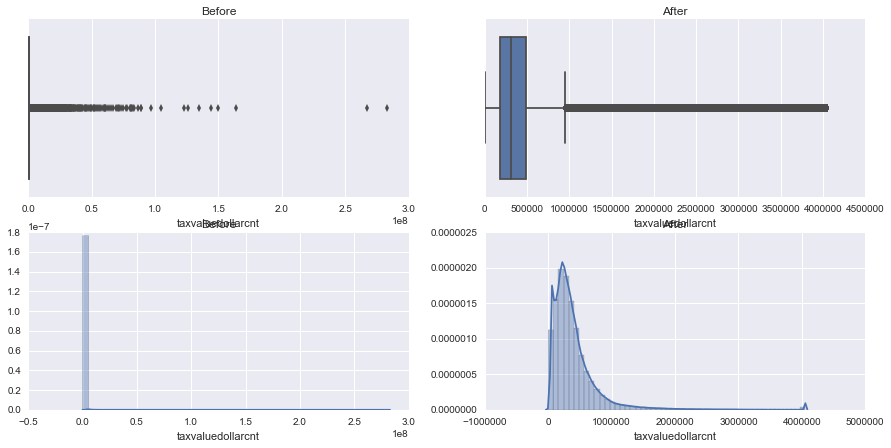

In [27]:
fix_outliers(data, 'taxvaluedollarcnt')

print('Before', data['taxvaluedollarcnt'].unique())
medTax = np.nanmedian(data['taxvaluedollarcnt'])
data['taxvaluedollarcnt'] = data['taxvaluedollarcnt'].fillna(medTax)
print('After', data['taxvaluedollarcnt'].unique())


### Variable: assessmentyear - year of the property tax assessment

Has datatype: ordinal and has 2 values missing

We replace the missing values with the latest tax year which also happens to be the median tax year.

In [28]:
print('Before', data['assessmentyear'].unique())
medAssessmentYear = np.nanmedian(data['assessmentyear'])
data['assessmentyear'] = data['assessmentyear'].fillna(medAssessmentYear).astype(np.int32)
print('After', data['assessmentyear'].unique())

Before [ 2015.  2014.  2003.  2012.  2001.  2011.  2013.  2016.  2010.    nan
  2004.  2005.  2002.  2000.  2009.]
After [2015 2014 2003 2012 2001 2011 2013 2016 2010 2004 2005 2002 2000 2009]


### Variable: landtaxvaluedollarcnt - the assessed value of the land

Has datatype: ratio and 1.89 percent of values missing

We replace all missing values with the median assessed land values

Outliers found!


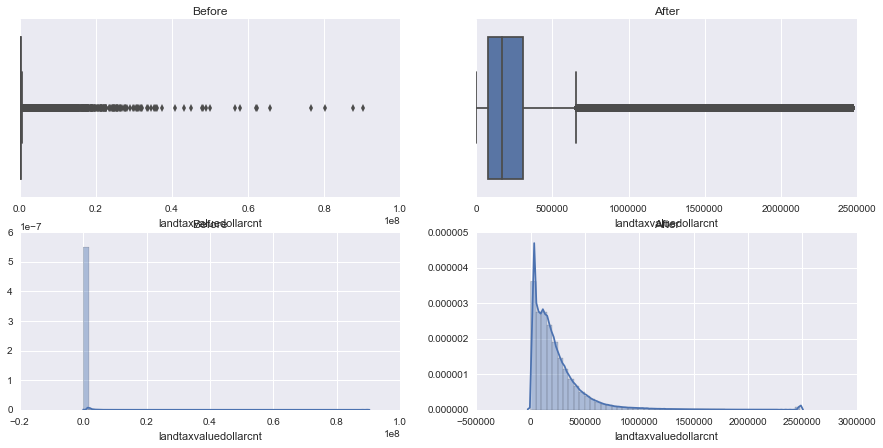

In [29]:
fix_outliers(data, 'landtaxvaluedollarcnt')
medLand = np.nanmedian(data['landtaxvaluedollarcnt'])
data['landtaxvaluedollarcnt'] = data['landtaxvaluedollarcnt'].fillna(medLand).astype(np.int32)


### Variable: taxamount - property tax for the assessment year

Has datatype: ratio and 0.66 percent of values missing

We replace all missing values with the median property taxes for the assessment year

Outliers found!


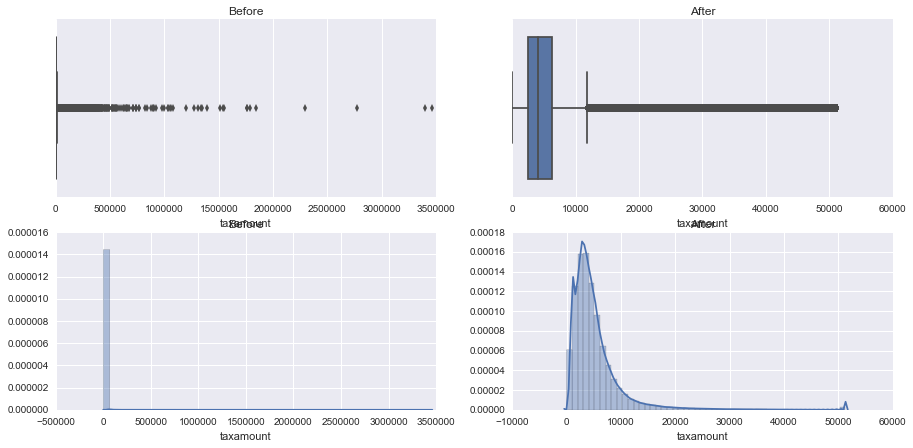

In [30]:
fix_outliers(data, 'taxamount')

medTax = np.nanmedian(data['taxamount'])
data['taxamount'] = data['taxamount'].fillna(medTax)

### Variable: taxdelinquencyflag - property taxes from 2015 that are past due

Has datatype: nominal and 98.10 percent of values missing

We replace all missing values with 0 representing no past due property taxes and all Y values with 1 representing that there are past due property taxes

In [31]:
print('Before', data['taxdelinquencyflag'].unique())
data['taxdelinquencyflag'] = data['taxdelinquencyflag'].fillna(0).replace('Y', 1).astype(np.int32)
print('After', data['taxdelinquencyflag'].unique())

Before [nan 'Y']
After [0 1]


### Variable: taxdelinquencyyear - years of deliquency

Has datatype: interval and 98.10 percent of values missing

We replace all missing values with 0 representing no years of property tax deliquencies

Outliers found!


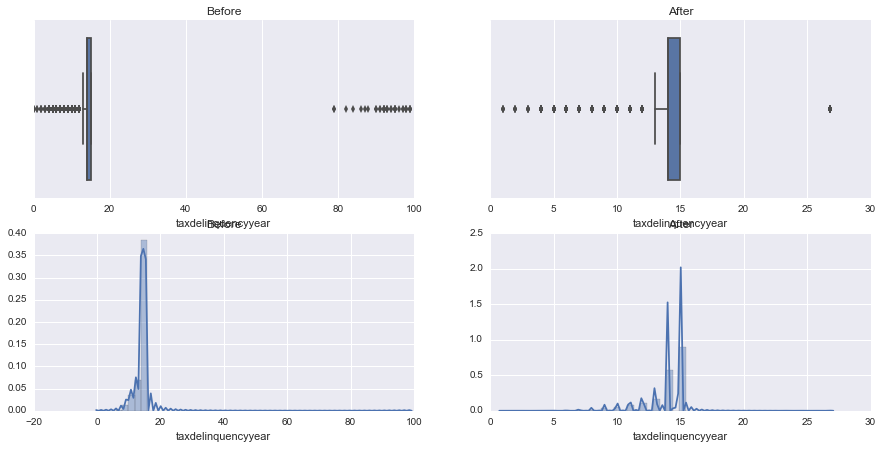

In [32]:
fix_outliers(data, 'taxdelinquencyyear')

data['taxdelinquencyyear'] = data['taxdelinquencyyear'].fillna(0)

### Variable: censustractandblock - census tract and census block ID

Has datatype: nominal and 2.14 percent of values missing

We replace all missing values with 

In [33]:
print('Before', data['censustractandblock'].unique())


Before [             nan   6.11100100e+13   6.11100090e+13 ...,   6.05909924e+13
   6.05906264e+13   6.03790121e+13]


### Variable: unitcnt - number of units in the building

Has datatype: ordinal and 33.5 percent of values missing

We replace all missing values with 1 to represent a single family home for any with no values.

Outliers found!
Before [        nan   2.          1.          3.          5.          4.          9.
  13.4204182  13.         12.          6.          7.          8.         10.
  11.       ]
Before [ 1  2  3  5  4  9 13 12  6  7  8 10 11]


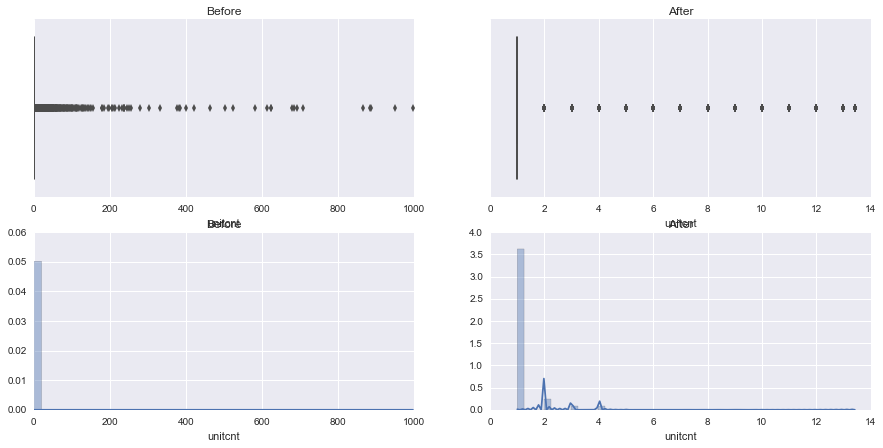

In [34]:
fix_outliers(data, 'unitcnt')

print('Before', data['unitcnt'].unique())
data['unitcnt'] = data['unitcnt'].fillna(1).astype(np.int32)
print('Before', data['unitcnt'].unique())

### Variable: pooltypeid2 - Pool with Spa/Hot Tub

Has datatype: ordinal and 98.9 percent of values missing 

We replace all missing values with 0 which will represent no Pool with Spa/Hot Tub.

In [35]:
print('Before', data['pooltypeid2'].unique())
data['pooltypeid2'] = data['pooltypeid2'].fillna(0).astype(np.int32)
print('After', data['pooltypeid2'].unique())

Before [ nan   1.]
After [0 1]


### Variable: pooltypeid7 - Pool without hot tub

Has datatype: ordinal and 83.6 percent of values missing 

We replace all missing values with 0 which will represent no Pool without hot tub.

In [36]:
print('Before', data['pooltypeid7'].unique())
data['pooltypeid7'] = data['pooltypeid7'].fillna(0).astype(np.int32)
print('After', data['pooltypeid7'].unique())

Before [ nan   1.]
After [0 1]


### Variable: propertycountylandusecode - County land use code i.e. it's zoning at the county level

Has datatype: ordinal and 0.02 percent of values missing 

We replace all missing values with 0 which will represent no County land use code.

In [37]:
print('Before', data['propertycountylandusecode'].unique()[:8].tolist() + ['...'])
data['propertycountylandusecode'] = data['propertycountylandusecode'].fillna(0).astype(np.str)
print('After', data['propertycountylandusecode'].unique()[:8].tolist() + ['...'])

Before ['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200', '...']
After ['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200', '...']


### Variable: propertylandusetypeid - Type of land use the property is zoned for

Has datatype: ordinal and 0 percent of values missing.

We are just changing the datatype to integer

In [38]:
data['propertylandusetypeid'] = data['propertylandusetypeid'].astype(np.int32)

### Variable: propertyzoningdesc - Description of the allowed land uses (zoning) for that property

Has datatype: ordinal and 33.4 percent of values missing 

We replace all missing values with 0 which will represent no Description of the allowed land uses.

In [39]:
print('Before', data['propertyzoningdesc'].unique())
data['propertyzoningdesc'] = data['propertyzoningdesc'].fillna(0).astype(np.str)
print('After', data['propertyzoningdesc'].unique())

Before [nan 'LCA11*' 'LAC2' ..., 'WCR1400000' 'EMPYYY' 'RMM2*']
After ['0' 'LCA11*' 'LAC2' ..., 'WCR1400000' 'EMPYYY' 'RMM2*']


### Variable: rawcensustractandblock - Census tract and block ID combined - also contains blockgroup assignment by extension

Has datatype: ordinal and 0 percent of values missing 

In [40]:
print('Before', data['rawcensustractandblock'].unique())
data['rawcensustractandblock'] = data['rawcensustractandblock'].fillna(0).astype(np.int32)
print('After', data['rawcensustractandblock'].unique())

Before [ 60378002.041     60378001.011002  60377030.012017 ...,  60590878.032022
  60590626.211013  60379012.091563]
After [60378002 60378001 60377030 ..., 61110057 60375324 60375991]


### Variable: regionidcity - Census tract and block ID combined - also contains blockgroup assignment by extension

Has datatype: ordinal and 0 percent of values missing 

In [41]:
data['regionidcity'] = data['regionidcity'].fillna(0).astype(np.int32)

### Variable: regionidcounty - County in which the property is located

Has datatype: ordinal and 0 percent of values missing 

In [42]:
data['regionidcounty'] = data['regionidcounty'].fillna(0).astype(np.int32)

### Variable: regionidneighborhood - City in which the property is located (if any)

Has datatype: ordinal and 61.1 percent of values missing 

We replace all missing values with 0 which will represent no region ID neighborhood.

In [43]:
data['regionidneighborhood'] = data['regionidneighborhood'].fillna(0).astype(np.int32)

### Variable: regionidzip - Zip code in which the property is located

Has datatype: ordinal and 0.08 percent of values missing 

We replace all missing values with 0 which will represent no zip code.

In [44]:
data['regionidzip'] = data['regionidzip'].fillna(0).astype(np.int32)

### Variable: roomcnt - Total number of rooms in the principal residence

Has datatype: nominal and 0.001 percent of values missing 

We replace all missing values with 0 which will represent no Total number of rooms in the principal residence reported.

Outliers found!
Before [  0.           8.           4.           5.           7.           6.          11.
   3.          10.           9.           2.          12.          15.67699991
  13.          15.          14.           1.                  nan]
After [ 0  8  4  5  7  6 11  3 10  9  2 12 15 13 14  1]


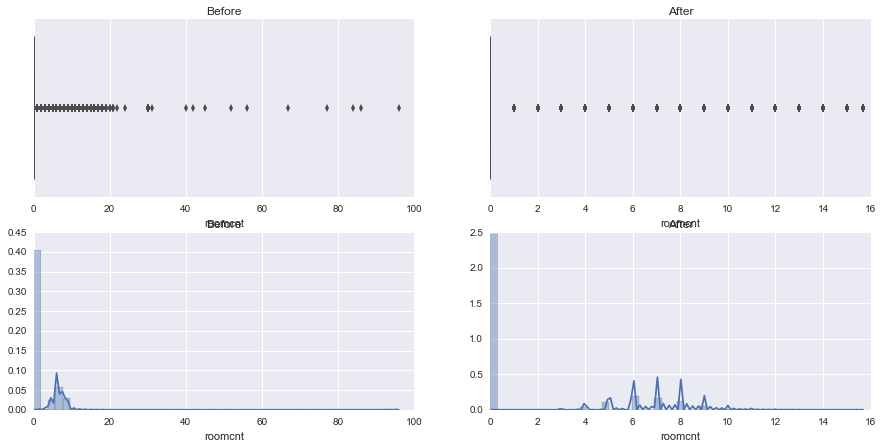

In [45]:
fix_outliers(data, 'roomcnt')

print('Before', data['roomcnt'].unique())
data['roomcnt'] = data['roomcnt'].fillna(0).astype(np.int32)
print('After', data['roomcnt'].unique())

### Variable: storytypeid - Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.

Has datatype: ordinal and 99.9 percent of values missing 

We replace all missing values with 0 which will represent no Type of floors in a multi-story house reported.

In [46]:
print('Before', data['storytypeid'].unique())
data['storytypeid'] = data['storytypeid'].fillna(0).astype(np.int32)
print('After', data['storytypeid'].unique())

Before [ nan   7.]
After [0 7]


### Variable: threequarterbathnbr - Number of 3/4 bathrooms in house (shower + sink + toilet)

Has datatype: nominal and 89.5 percent of values missing 

We replace all missing values with 0 which will represent no Number of 3/4 bathrooms in house.

Outliers found!
Before [        nan  1.          1.59854253]
After [0 1]


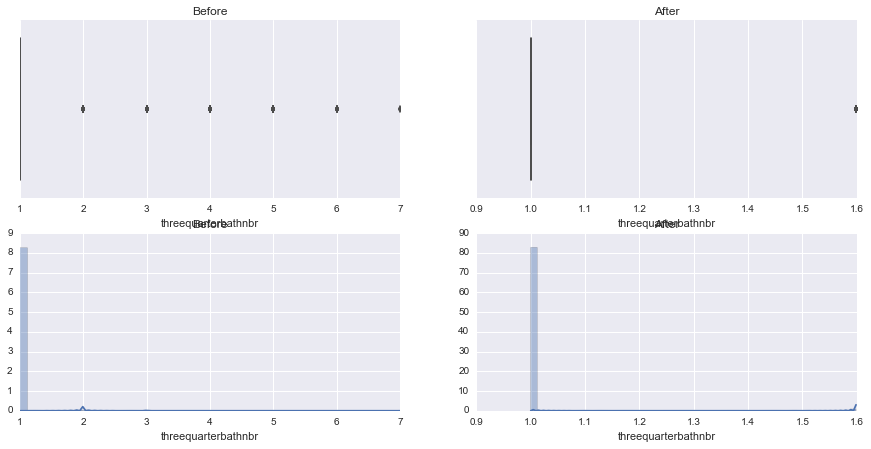

In [47]:
fix_outliers(data, 'threequarterbathnbr')

print('Before', data['threequarterbathnbr'].unique())
data['threequarterbathnbr'] = data['threequarterbathnbr'].fillna(0).astype(np.int32)
print('After', data['threequarterbathnbr'].unique())

### Variable: typeconstructiontypeid - What type of construction material was used to construct the home

Has datatype: ordinal and 99.7 percent of values missing 

We replace all missing values with 0 which will represent no construction type id reported.

In [48]:
print('Before', data['typeconstructiontypeid'].unique())
data['typeconstructiontypeid'] = data['typeconstructiontypeid'].fillna(0).astype(np.int32)
print('After', data['typeconstructiontypeid'].unique())

Before [ nan   6.   4.  10.  13.  11.]
After [ 0  6  4 10 13 11]


### Variable: airconditioningtypeid - Type of cooling system present in the home (if any)
Has datatype: nominal and 72.710860 percent of values missing 

For this variable, missing values indicate the absence of a cooling system. As a resut, we imputed zero to missing values.

In [49]:
print('Before', data['airconditioningtypeid'].unique())
data['airconditioningtypeid'] = data['airconditioningtypeid'].fillna(0).astype(np.int32)
print('After', data['airconditioningtypeid'].unique())

Before [ nan   1.  13.   5.  11.   9.  12.   3.]
After [ 0  1 13  5 11  9 12  3]


### Variable: architecturalstyletypeid - Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
Has datatype: nominal and 99.796185 percent of values missing 

Architectural style describes the home design. As such, it is not something we can extrapolate a value for. With over 99% of values missing, we decided to eliminate this variable.

In [50]:
del data['architecturalstyletypeid']

### Variable: basementsqft - Finished living area below or partially below ground level
Has datatype: ratio and 99.945255 percent of values missing

Basements are not standard home features. Whenever a basement is not a feature of the home, the value for area was entered as a missing value. Therefore, we replaced missing values with zeros. Some high outliers are removed

Outliers found!


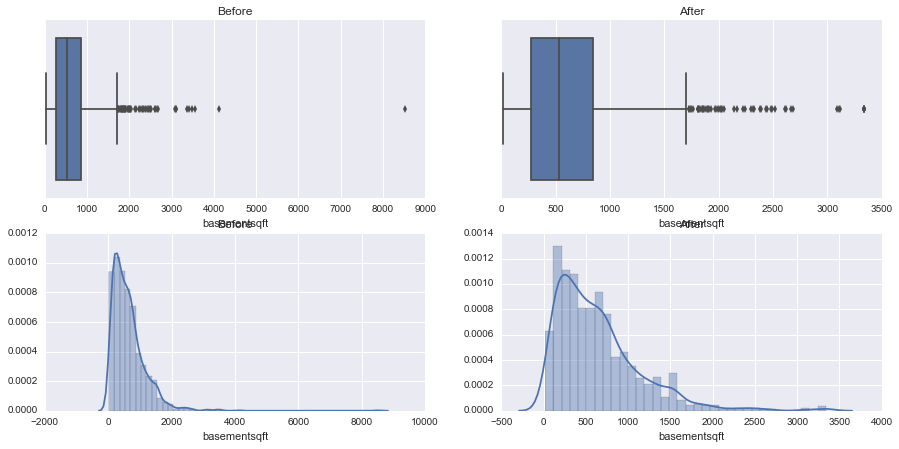

In [51]:
fix_outliers(data, 'basementsqft')

data['basementsqft'] = data['basementsqft'].fillna(0).astype(np.int32)

assert data['basementsqft'].min() >= 0

### Variable: bathroomcnt - Number of bathrooms in home including fractional bathrooms
Has datatype: ordinal and 0.000841 percent of values missing

We decided to replace missing values with zeros since there are only very few. 


In [52]:
print('Before', data['bathroomcnt'].unique())
data['bathroomcnt'] = data['bathroomcnt'].fillna(0).astype(np.int32)
print('After', data['bathroomcnt'].unique())

Before [  0.     2.     4.     3.     1.     2.5    3.5    5.     1.5    4.5    7.5
   5.5    6.     7.    10.     8.     9.    12.    11.     8.5    6.5   13.
   9.5   14.    20.    19.5   15.    10.5     nan  18.    16.     1.75  17.
  19.     0.5   12.5   11.5   14.5 ]
After [ 0  2  4  3  1  5  7  6 10  8  9 12 11 13 14 20 19 15 18 16 17]


### Variable: bedroomcnt - Number of bedrooms in home
Has datatype: ordinal and 0.000437 percent of values missing

We decided to replace missing values with zeros since there are only very few. 

In [53]:
print('Before', data['bedroomcnt'].unique())
data['bedroomcnt'] = data['bedroomcnt'].fillna(0).astype(np.int32)
print('After', data['bedroomcnt'].unique())

Before [  0.   4.   5.   2.   3.   1.   6.   7.   8.  12.  11.   9.  10.  14.  16.
  13.  nan  15.  17.  18.  20.  19.]
After [ 0  4  5  2  3  1  6  7  8 12 11  9 10 14 16 13 15 17 18 20 19]


### Variable: buildingqualitytypeid - Overall assessment of condition of the building from best (lowest) to worst (highest)
Has datatype: ordinal and 99.576949 percent of values missing

With this much missing values and the difficulty of estimating property condition, we deceided to remove this variable.

In [54]:
del data['buildingqualitytypeid']

### Variable: buildingclasstypeid - The building framing type (steel frame, wood frame, concrete/brick)
Has datatype: nominal and 99.576949 percent of values missing

With this much missing values and the difficulty of assigning a building framing type, we deceided to remove this variable.

In [55]:
del data['buildingclasstypeid']

### Variable: calculatedbathnbr - Number of bathrooms in home including fractional bathroom
Has datatype: nominal and 4.318346 percent of values missing

With a low number of missing values, we decided to assign 1 to all missing values since each property should have at least 1 bathroom.

In [56]:
print('Before', data['calculatedbathnbr'].unique())
data['calculatedbathnbr'] = data['calculatedbathnbr'].fillna(1).astype(np.int32)
print('After', data['calculatedbathnbr'].unique())

Before [  nan   2.    4.    3.    1.    2.5   3.5   5.    1.5   4.5   7.5   5.5
   6.    7.   10.    8.    9.   12.   11.    8.5   6.5  13.    9.5  14.
  20.   19.5  15.   10.5  18.   16.   17.   19.   12.5  11.5  14.5]
After [ 1  2  4  3  5  7  6 10  8  9 12 11 13 14 20 19 15 18 16 17]


### Variable: decktypeid - Type of deck (if any) present on parcel
Has datatype: nominal and 99.427311 percent of values missing

Missing values is most likely an indication of an absence of this feature in the property. Based on this, we decided to impute zeros to missing values.

In [57]:
print('Before', data['decktypeid'].unique())
data['decktypeid'] = data['decktypeid'].fillna(0).astype(np.int32)
print('After', data['decktypeid'].unique())

Before [ nan  66.]
After [ 0 66]


### Variable: threequarterbathnbr - Number of 3/4 bathrooms in house (shower + sink + toilet)
Has datatype: nominal and 93.209304 percent of values missing

Missing values is most likely an indication of an absence of this feature in the property. Based on this, we decided to impute zeros to missing values.

In [58]:
print('Before', data['threequarterbathnbr'].unique())
data['threequarterbathnbr'] = data['threequarterbathnbr'].fillna(0).astype(np.int32)
print('After', data['threequarterbathnbr'].unique())

Before [0 1]
After [0 1]


### Variable: finishedfloor1squarefeet - Size of the finished living area on the first (entry) floor of the home
Has datatype: ratio and 93.209304 percent of values missing

Having this much missing values and the availability of an alternate variable - calculatedfinishedsquarefeet - with very few missing values, we decided to eliminate this variable.

In [59]:
del data['finishedfloor1squarefeet']

### Variable: calculatedfinishedsquarefeet - Calculated total finished living area of the home
Has datatype: ratio and 1.861339 percent of values missing

These missing values appear to be consistent with 0 or missing values for variables associated with a building or structure on the proeprty such as bathroomcnt, bedroomcnt, or architecturalstyletypeid. We can assume that no structures exist on these properties and we decided to impute zeros to these.

In [60]:
data['calculatedfinishedsquarefeet'] = data['calculatedfinishedsquarefeet'].fillna(0).astype(np.int32)

### Variable: finishedsquarefeet6 - Base unfinished and finished area
Has datatype: ratio and ?????? percent of values missing

The finishedsquarefeet fields add up to the calculatedfinishedsquarefeet. Missing values are therefore zeros.

In [61]:
#data['finishedsquarefeet12'] = data['finishedsquarefeet6'].fillna(0).astype(np.int32)

### Variable: finishedsquarefeet13 - Finished living area
Has datatype: ratio and 99.743000 percent of values missing

The finishedsquarefeet fields add up to the calculatedfinishedsquarefeet. Missing values are therefore zeros.

In [62]:
data['finishedsquarefeet13'] = data['finishedsquarefeet13'].fillna(0).astype(np.int32)

### Variable: finishedsquarefeet12 - Finished living area
Has datatype: ratio and 9.246664 percent of values missing

The finishedsquarefeet fields add up to the calculatedfinishedsquarefeet. Missing values are therefore zeros.

In [63]:
data['finishedsquarefeet12'] = data['finishedsquarefeet12'].fillna(0).astype(np.int32)

### Variable: finishedsquarefeet15 - Finished living area
Has datatype: ratio and 93.608572 percent of values missing

The finishedsquarefeet fields add up to the calculatedfinishedsquarefeet. Missing values are therefore zeros.

In [64]:
data['finishedsquarefeet15'] = data['finishedsquarefeet15'].fillna(0).astype(np.int32)

### Variable: finishedsquarefeet50 - Finished living area
Has datatype: ratio and 93.209304 percent of values missing

The finishedsquarefeet fields add up to the calculatedfinishedsquarefeet. Missing values are therefore zeros.

In [65]:
data['finishedsquarefeet50'] = data['finishedsquarefeet50'].fillna(0).astype(np.int32)

# Simple Statistics
<b>10 points</b>

<i>
<b>Description:</b><br/>
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 
</i>

<b>Answer:</b><br/>
...

In [66]:
# code here

# Visualize Attributes
<b>15 points</b>

<i>
<b>Description:</b><br/>
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.
</i>

<b>Answer:</b><br/>
...

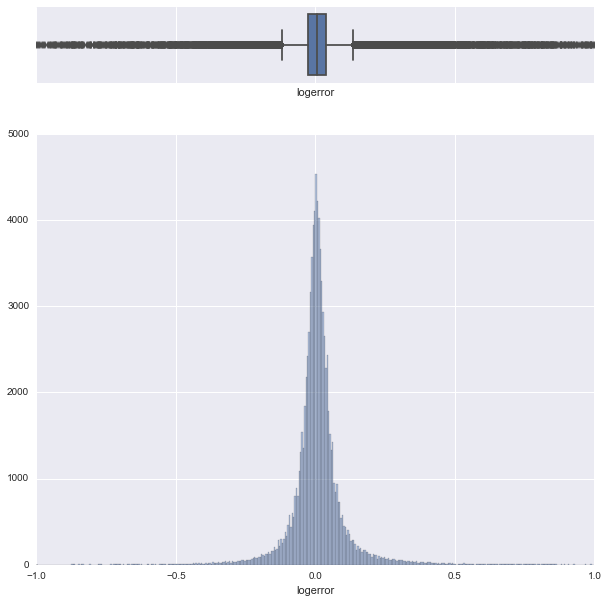

In [67]:
train_data = data[~data['logerror'].isnull()]

#sns.distplot(train_data['logerror'][train_data['logerror'].abs()<1])

x = train_data['logerror']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
    gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 10))
sns.boxplot(train_data['logerror'][train_data['logerror'].abs()<1], ax=ax_box)
sns.distplot(train_data['logerror'][train_data['logerror'].abs()<1], ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

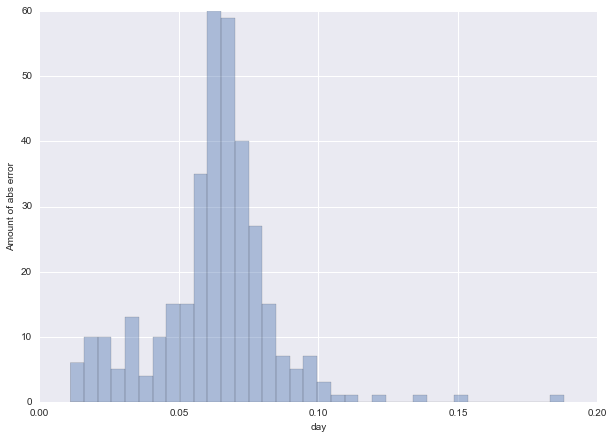

In [69]:
train_data = data[~data['logerror'].isnull()]

error_per_day = train_data['logerror'].abs().groupby(train_data['transactiondate']).mean()
sns.distplot(error_per_day, kde=False);
plt.ylabel('Amount of abs error', fontsize=10)
plt.xlabel('day', fontsize=10)

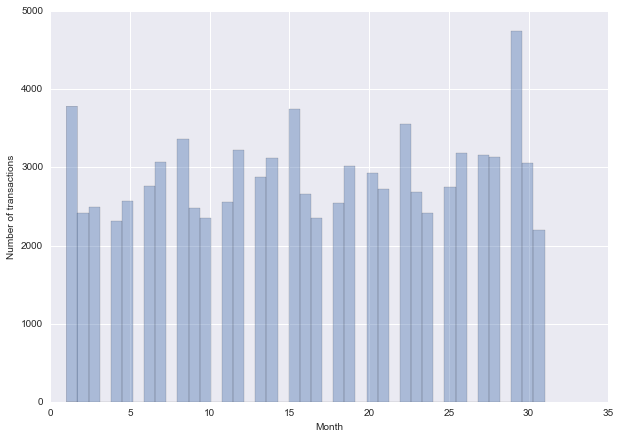

In [70]:
transaction_month = train_data['transactiondate'].dt.day
sns.distplot(transaction_month, kde=False);
plt.ylabel('Number of transactions', fontsize=10)
plt.xlabel('Month', fontsize=10)

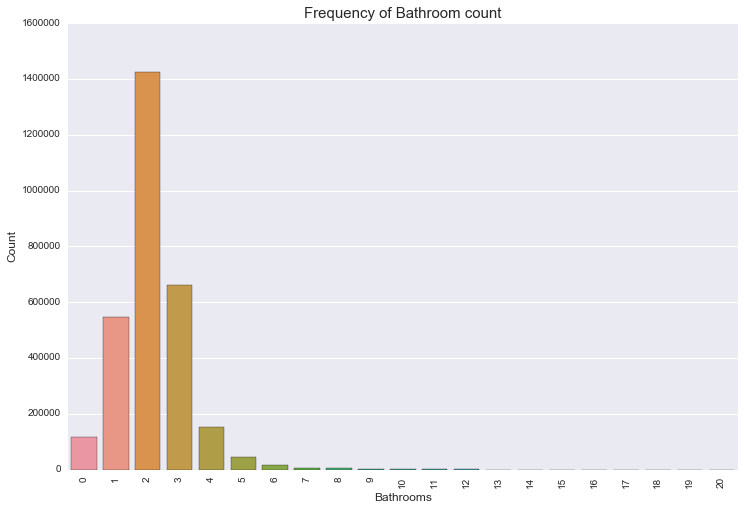

In [71]:
plt.figure(figsize=(12,8))
sns.countplot(data['bathroomcnt'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathrooms', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)

# Explore Joint Attributes
<b>15 points</b>

<i>
<b>Description:</b><br/>
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.
</i>

<b>Answer:</b><br/>
...

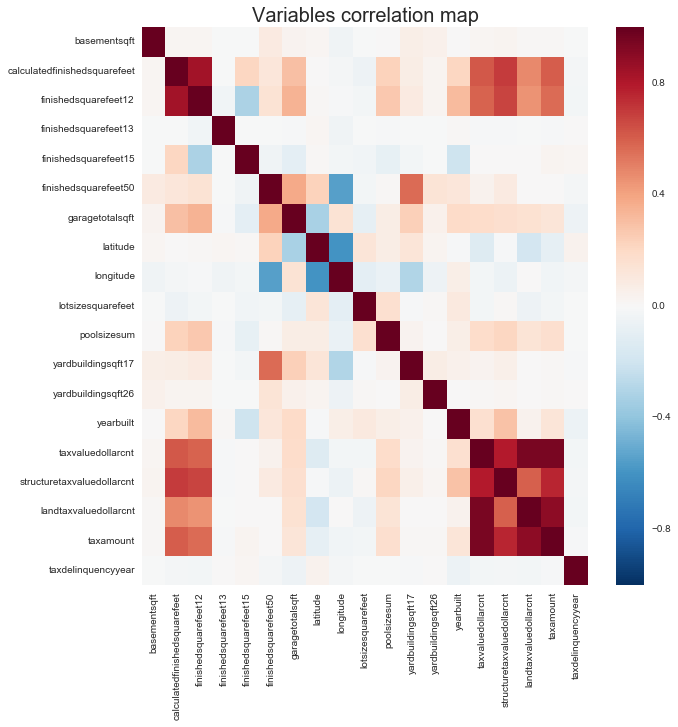

In [72]:
train_data = data[~data['logerror'].isnull()]

continious_vars = variables[variables['type'].isin(['ratio', 'interval'])].index
continious_vars = continious_vars[continious_vars.isin(data.columns)]

corrs = train_data[continious_vars].corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrs, ax=ax)
plt.title("Variables correlation map", fontsize=20)

# Explore Attributes and Class
<b>10 points</b>

<i>
<b>Description:</b><br/>
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).
</i>

<b>Answer:</b><br/>
...

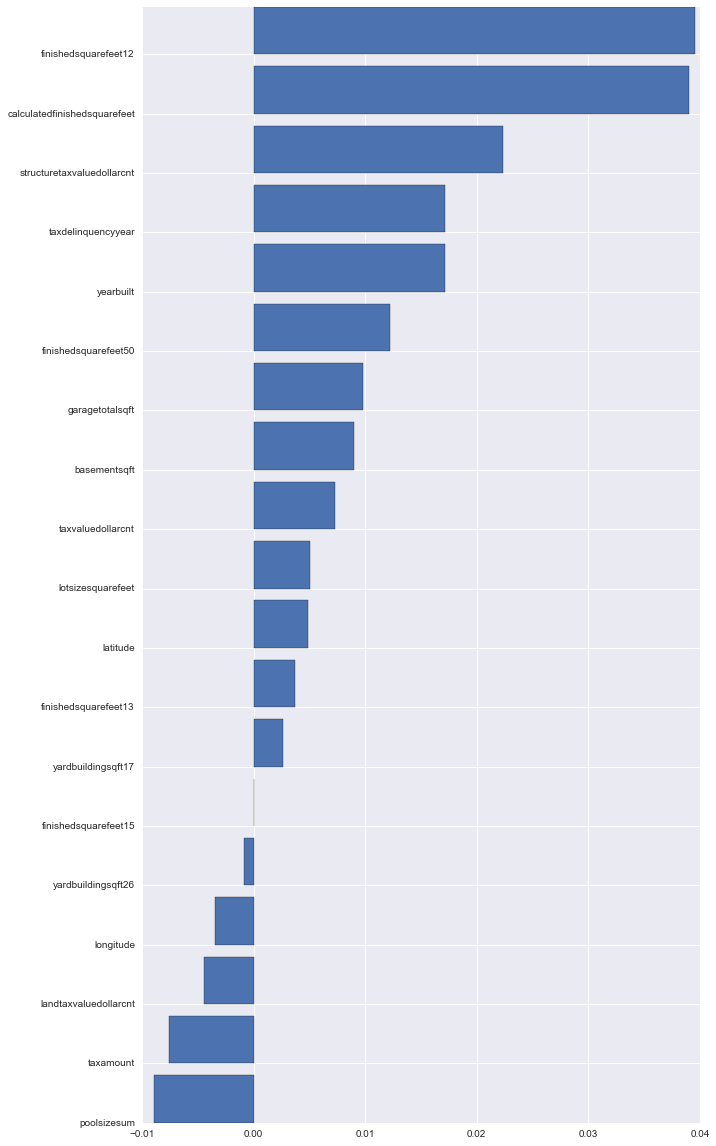

In [73]:
train_data = data[~data['logerror'].isnull()]

continious_vars = variables[variables['type'].isin(['ratio', 'interval'])].index
continious_vars = continious_vars[continious_vars.isin(data.columns)]

labels = []
values = []
for column in continious_vars:
    labels.append(column)
    values.append(train_data[column].corr(train_data['logerror']))
    
corr = pd.DataFrame({'labels':labels, 'values':values})
corr = corr.sort_values(by='values')
labels = corr['labels'].values
values = corr['values'].values

fig, ax = plt.subplots(figsize=(10,20))
ax.set_yticks(range(len(labels)))
plt.barh(range(len(labels)), values)
#ax = plt.gca()
ax.set_yticklabels(labels, rotation='horizontal');


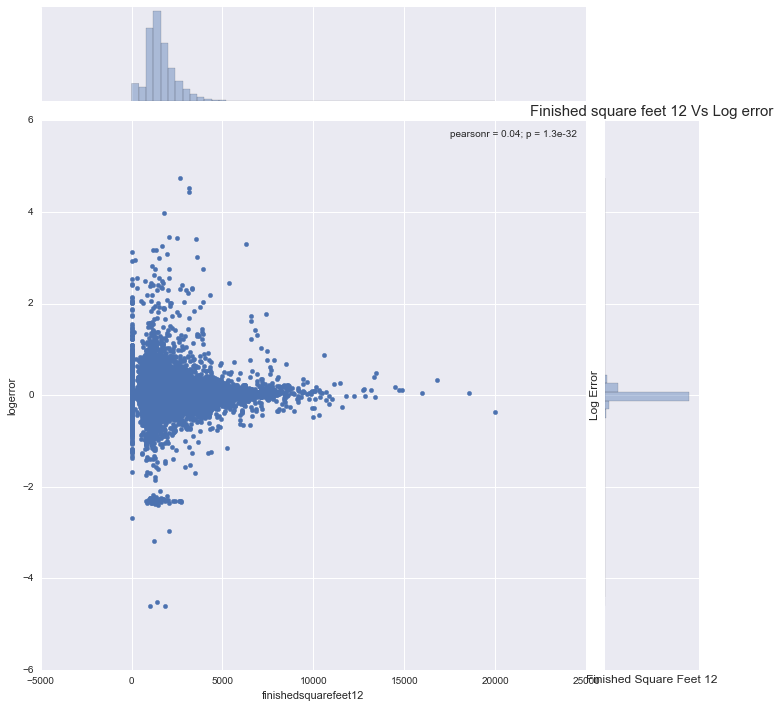

In [74]:
column = "finishedsquarefeet12"
train_data = data[~data['logerror'].isnull()]


sns.jointplot(train_data[column], train_data['logerror'], size=10)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)

# New Features
<b>5 points</b>

<i>
<b>Description:</b><br/>
Are there other features that could be added to the data or created from existing features? Which ones?
</i>

<b>Answer:</b><br/>
...

# This is work in progress ...

Name	Type	Description
Zipcode	Text	5 digit Zipcode or military postal code(FPO/APO)
ZipCodeType	Text	Standard, PO BOX Only, Unique, Military(implies APO or FPO)
City	Text	USPS offical city name(s)
State	Text	USPS offical state, territory, or quasi-state (AA, AE, AP) abbreviation code
LocationType	Text	Primary, Acceptable,Not Acceptable
Lat	Double	Decimal Latitude, if available
Long	Double	Decimal Longitude, if available
Location	Text	Standard Display  (eg Phoenix, AZ ; Pago Pago, AS ; Melbourne, AU )
Decommisioned	Text	If Primary location, Yes implies historical Zipcode, No Implies current Zipcode; If not Primary, Yes implies Historical Placename
TaxReturnsFiled	Long Integer	Number of Individual Tax Returns Filed in 2008
EstimatedPopulation	Long Integer	Tax returns filed + Married filing jointly + Dependents
TotalWages	Long Integer	Total of Wages Salaries and Tips

In [75]:
# http://federalgovernmentzipcodes.us
zips = pd.read_csv('../input/free-zipcode-database.csv')
zips = zips[['Zipcode','ZipCodeType','City','State','LocationType']]

assert np.all(~zips.isnull())

zips = zips.rename(columns={'Zipcode':'regionidzip'})

data['regionidzip'] = data['regionidzip'].fillna(0).astype(np.int32)
data = pd.merge(data, zips, how='left', on='regionidzip')

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exceptional Work
<b>10 points</b>

<i>
<b>Description:</b><br/>
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.
</i>

<b>Answer:</b><br/>

TODO:
- plot of a heat map
- analysis of feature importance
- a model